# Cats Dogs redux playground


## Overview

Transfer Learning on ImageNet trained ResNet18 Model to learn cats vs dogs

The data is from the Kaggle Competetion [link](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)  

---


*Tags:* `pytorch` `fastai` `resnet`

In [1]:
!pwd

/home/gautam/notebooks/pers_d2/kaggle_cats_dogs_redux


In [3]:
import os, sys
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/data'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from glob import glob
from shutil import copyfile


In [5]:
from fastai.vision import *

## The Data

The downloaded data has the following structure

In [53]:
!tree $DATA_HOME_DIR -L 2

/home/gautam/notebooks/pers_d2/kaggle_cats_dogs_redux/data
├── models
│   ├── tmp.h5
│   └── tmp.pth
├── results
│   └── submission_resnet_50_3epoch.csv
├── sample
│   ├── models
│   ├── results
│   ├── test
│   ├── tmp
│   ├── train
│   └── valid
├── test
│   ├── test
│   └── unknown
├── tmp
│   ├── x_act_resnet34_0_224.bc
│   ├── x_act_test_resnet34_0_224.bc
│   └── x_act_val_resnet34_0_224.bc
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

22 directories, 3 files


A `sample` folder was created to have the same folder structure to test the code on a small sample

In [57]:
!tree $DATA_HOME_DIR/sample/valid -L 3

/home/gautam/notebooks/pers_d2/kaggle_cats_dogs_redux/data/sample/valid
├── cats
│   ├── cat.10012.jpg
│   ├── cat.10214.jpg
│   ├── cat.10447.jpg
│   ├── cat.1579.jpg
│   ├── cat.185.jpg
│   ├── cat.2842.jpg
│   ├── cat.2854.jpg
│   ├── cat.3313.jpg
│   ├── cat.3408.jpg
│   ├── cat.349.jpg
│   ├── cat.3717.jpg
│   ├── cat.3803.jpg
│   ├── cat.4161.jpg
│   ├── cat.4815.jpg
│   ├── cat.4944.jpg
│   ├── cat.7306.jpg
│   ├── cat.7558.jpg
│   ├── cat.8044.jpg
│   ├── cat.9141.jpg
│   ├── cat.931.jpg
│   ├── cat.9706.jpg
│   └── cat.9881.jpg
└── dogs
    ├── dog.1009.jpg
    ├── dog.10175.jpg
    ├── dog.10341.jpg
    ├── dog.10438.jpg
    ├── dog.11304.jpg
    ├── dog.11378.jpg
    ├── dog.12354.jpg
    ├── dog.1365.jpg
    ├── dog.160.jpg
    ├── dog.1954.jpg
    ├── dog.2151.jpg
    ├── dog.2389.jpg
    ├── dog.2723.jpg
    ├── dog.2832.jpg
    ├── dog.2833.jpg
    ├── dog.3476.jpg
    ├── dog.4647.jpg
    ├── dog.6050.jpg
    ├── dog.6523.jpg
    ├── dog.6671.jpg
    ├── dog.6774.jpg
  

## Training



In [46]:
sz = 224 #Image size
arch = models.resnet18 # Model architecture
bs = 32 #Training batch size
is_trial_run = False #Toggle using sample data vs the full dataset

train_path = DATA_HOME_DIR + '/sample' if is_trial_run else DATA_HOME_DIR #Path the the data for fastai databunch

data = ImageDataBunch.from_folder(train_path,train='train',valid="valid", size=sz)
learn = cnn_learner(data, arch, metrics=accuracy) #Fastai helper to transfer learning

### cnn_learner

What does the model in `learn` look like?

In [61]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The head is a custom one. Interesting changes here:

    -Adaptive concat pool used -  Concatenating the Avg and Max pools of the last conv layer
    -Instead of just one Dense layer as head, we are using two
    -BatchNorm and Dropout regularization

Loss Function:

In [64]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Data sample

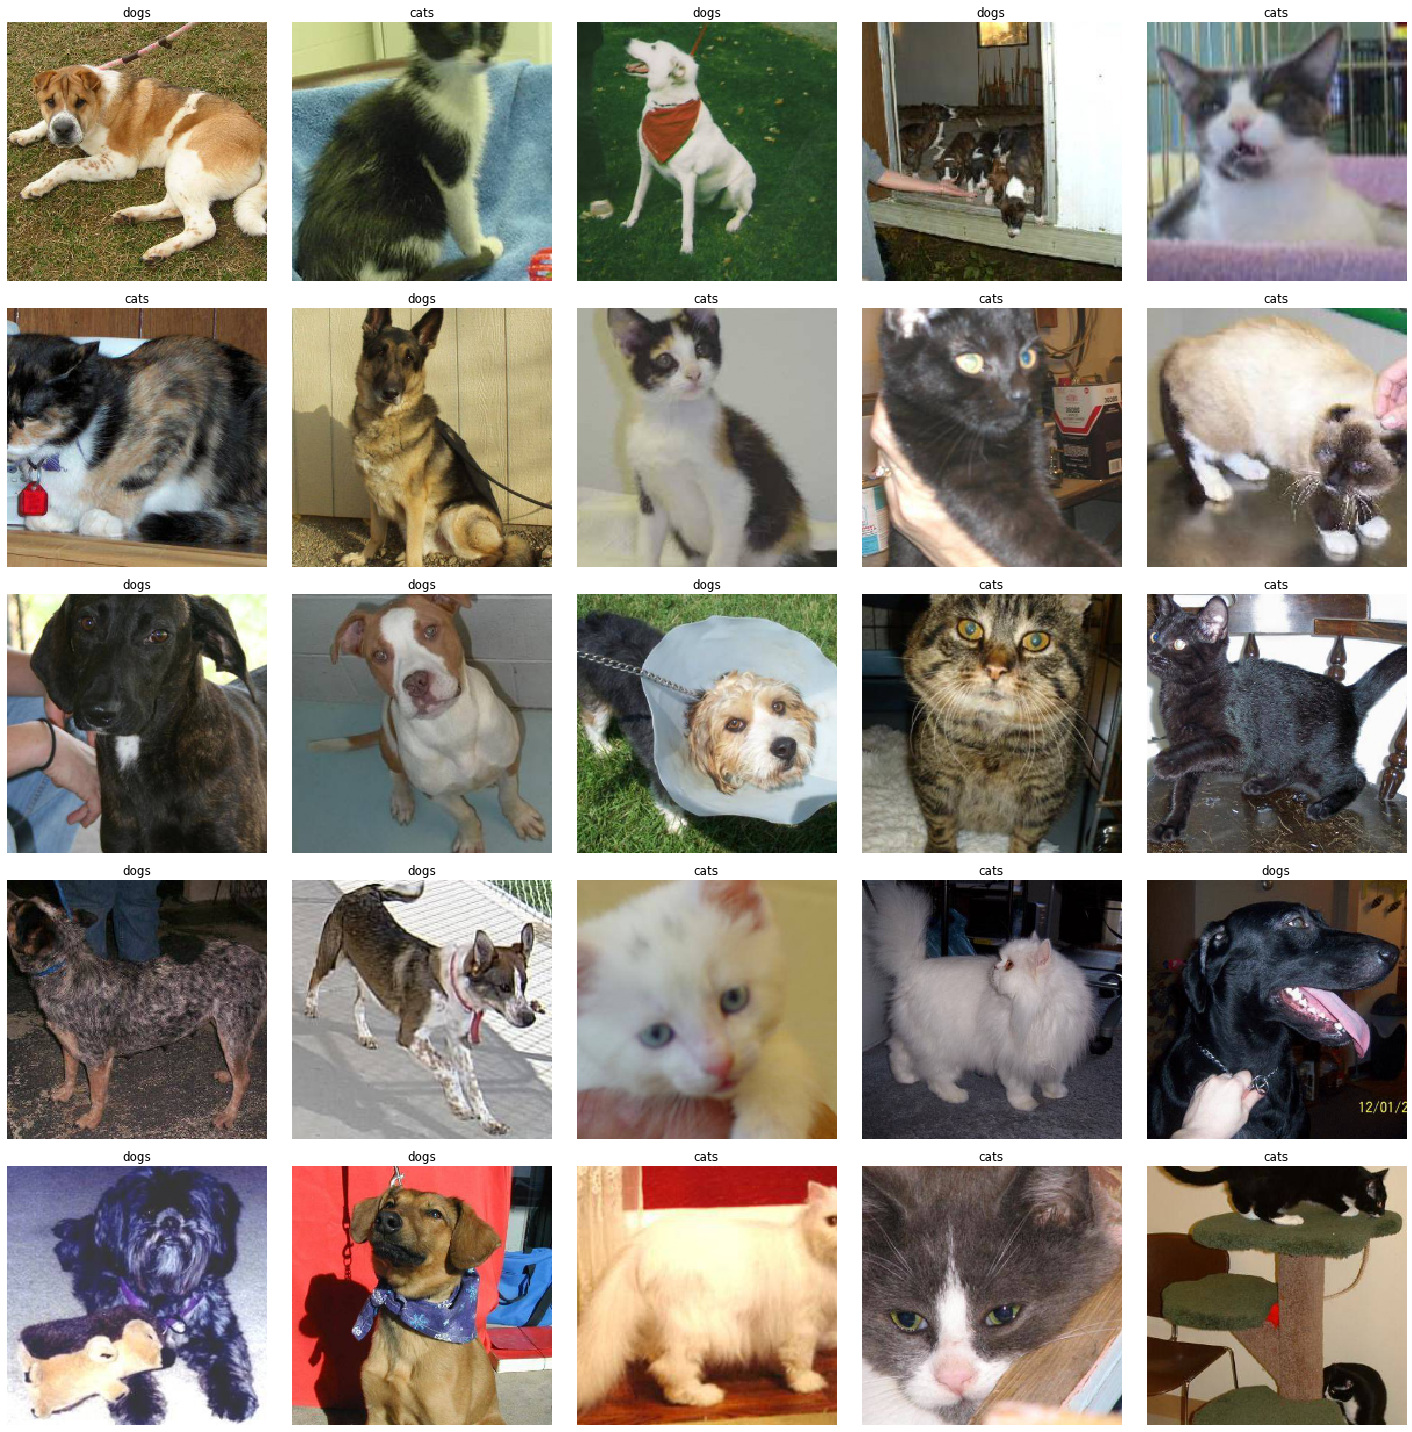

In [65]:
data.show_batch()

### Step 1 - Find optimal LR

Fastai provides a convenient `lr_find` function to find the optimal learning rate

In [66]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


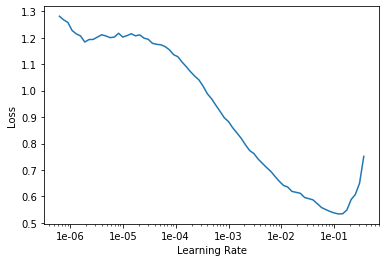

In [68]:
learn.recorder.plot()

The idea behind the learning rate finder is to check the loss on training model with exponentially increasing learning rates on small batches of the data, inorder to estimate value of lr which is conducive to maximal learning of the network.

![pyimagesearch_lr_finder_sample_plot](https://www.pyimagesearch.com/wp-content/uploads/2019/08/learing_rate_finder_lr_plot.png)
Source:[pyimagesearch](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/)

Checkout this [blog](https://www.pyimagesearch.com/2019/08/05/keras-learning-rate-finder/) at PyimageSearch for an implementation in Keras and some more in-depth explanation

The concept was first introduced by Leslie Smith in his paper, [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf)

So based on the `lr-finder`  I will choose **1e-02** as the lr

In [71]:
lr = 1e-2

### Step 2 - Fit one cycle

One-cycle policy training is another technique introduced in the paper, [A disciplined approach to neural network hyper parameter training Part 1](https://arxiv.org/pdf/1803.09820.pdf)

An explainer on the implementation here can be found in the [fast.ai docs - callbacks.one_cycle](https://docs.fast.ai/callbacks.one_cycle.html)

In [73]:
learn.fit_one_cycle(cyc_len=2, 
                    max_lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.122651,0.064753,0.974500,00:58
1,0.054298,0.029385,0.987500,00:50


The accuracy on the validation set is already 98.7%, and the validation log-loss is 0.029.

This beats the 1st place in the [leaderboard](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/leaderboard) !

We can check the learning rate change in the 2 epochs we just trained

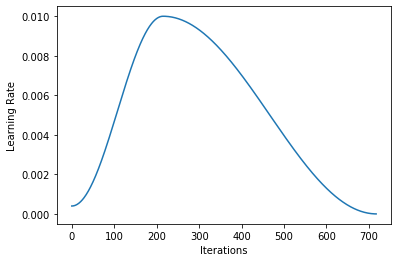

In [74]:
learn.recorder.plot_lr()

In [75]:
interp = ClassificationInterpretation.from_learner(learn)

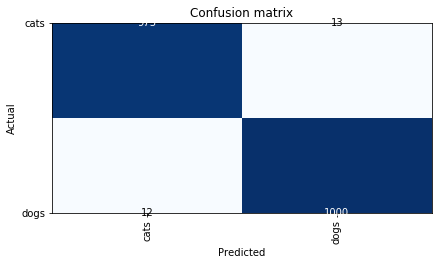

In [76]:
interp.plot_confusion_matrix()

13 cats misclassified as dogs and 12 vice-versa on the valid dataset

#### Checkpoint

In [78]:
learn.save('cats_dogs_model_0293_v1')

### Step 3 - Fit some more

with slightly smaller learning rate

In [82]:
learn.fit(2, 5*1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.080805,0.047100,0.981500,00:50
1,0.078737,0.062413,0.976000,00:52


#### Revert

In [84]:
_ = learn.load('cats_dogs_model_0293_v1')

###  Step 4 - Fit with one cycle for 1 more epoch

In [85]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.034948,0.025763,0.989000,00:50


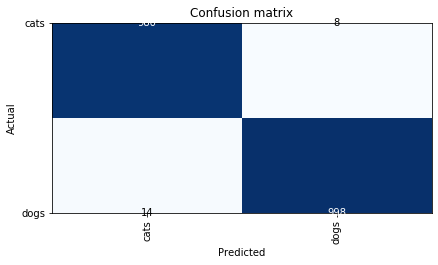

In [86]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Checkpoint

In [87]:
learn.save('cats_dogs_model_0257_v2')

In [98]:
torch.save(learn.model.state_dict(), open('data/models/cats_dogs_model_0257_v2.model', 'wb'))

We can try training some more, but lets stop here and continue with the prediction pipeline first

## Prediction pipeline

In [167]:

import torch
from torch import nn
import torchvision.models as models
from PIL import Image
from  torchvision import transforms


class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        sz = sz or 1
        self.ap,self.mp = nn.AdaptiveAvgPool2d(sz), nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    
class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full
    
    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)    

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        base_model = models.resnet18(pretrained=False)
        base_model = nn.Sequential(*[m for m in base_model.children()][:-2])
        head = nn.Sequential(AdaptiveConcatPool2d(), 
                Flatten(), 
                nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.25),
                nn.Linear(in_features=1024, out_features=512, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True),
                nn.Dropout(p=0.5),
                nn.Linear(in_features=512, out_features=2, bias=True))
        self.model = nn.Sequential(base_model, head)

    def forward(self, x):
        x = self.model(x)
        return x   
        
    def load_state_dict(self, *args, **kwargs):
        self.model.load_state_dict(torch.load( *args, **kwargs))
        
    def set_eval(self):
        self.model = self.model.eval()
        
    def to_cpu(self):
        self.model = self.model.cpu()
        
    def predict(self, x):
        start = time()
        x = x.unsqueeze(0)
        confidences = self.model(*[x])
        confidences = torch.softmax(confidences, dim=1).detach().numpy()[0]
        return confidences

    def preprocess_image(self, im):	    
        im = im.convert('RGB')
        im = transforms.Resize(256)(im)
        im = transforms.CenterCrop(224)(im)
        im = transforms.ToTensor()(im)
        im = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])(im)
        return im


class CatsDogsModel(Model):

    def predict(self, x):
        confidences = super().predict(x)
        pred = np.argmax(confidences)
        
        res = {
            "cat_or_dog": "cat" if pred==0 else "dog",
            "confidence": round(confidences[pred],2)
        }
        return res

    def score(self, im):
        im = self.preprocess_image(im)
        prediction = self.predict(im)
        return prediction    

    def score_image_from_path(self, img_path):
        im = PIL.Image.open(img_path)
        prediction = self.score(im)
        return prediction        

    def score_image_from_url(self, url):        
        img_request = requests.get(url, stream=True)
        im = PIL.Image.open(io.BytesIO(img_request.content))
        prediction = self.score(im)
        return prediction

In [168]:
model = CatsDogsModel()
model.load_state_dict(f='data/models/cats_dogs_model_0257_v2.model', map_location='cpu')
model.set_eval()

In [169]:
model.score_image_from_path(DATA_HOME_DIR+'/sample/valid/cats/cat.931.jpg')

{'cat_or_dog': 'cat', 'confidence': 0.96}

In [170]:
model.score_image_from_url("https://d2ph5fj80uercy.cloudfront.net/06/cat129.jpg") #Actually a cat

{'cat_or_dog': 'cat', 'confidence': 1.0}

In [171]:
# Actually a dog image
model.score_image_from_url("https://i.guim.co.uk/img/media/d6fe2d265ac0b06b00f687f6c25ba9c32b57ac37/0_164_5400_3240/master/5400.jpg?width=300&quality=85&auto=format&fit=max&s=26062d3c714347a4e124629f7a9f6427")

{'cat_or_dog': 'dog', 'confidence': 0.89}